In [1]:
import declust as dc
import scanpy as sc

Loading Data



In [ ]:
# Load your spatial data and your single cell data (which should be in AnnData format)

sc_adata = sc.read_h5ad('data/sc_adata.h5ad')
st_adata = sc.read_h5ad('data/st_adata.h5ad')
st_adata.var_names_make_unique()
sc_adata.var_names_make_unique()

coords_df = st_adata.obs.rename(columns={'array_row': 'x', 'array_col': 'y'})[['x', 'y']]

Data Preprocessing

In [ ]:
# Normalization

sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)

sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [ ]:
# Selection of highly variable genes for marker gene identification and clustering

st_top_500_genes_df = st_adata[
    :, dc.preprocessing.select_highly_variable_genes(st_adata, n_top_genes=500)
].to_df()

high_variable_common_genes = set(
    dc.preprocessing.select_highly_variable_genes(st_adata, n_top_genes=5000)
).intersection(sc_adata.var_names)

sc_adata_overlapped = sc_adata[:, list(high_variable_common_genes)].copy()
sc_labels = dc.preprocessing.extract_labels_from_scdata(
    sc_adata_overlapped, celltype_col='celltype_major', sample_col='Patient'
)

In [ ]:
# Save the data for next steps

sc_adata_overlapped.to_df().to_csv('data/sc_adata_overlapped.csv')
sc_labels.to_csv('data/sc_labels.csv')

Built Reference Matrix


In [ ]:
# Build a cell type reference matrix from annotated scRNA seq data.

sc_marker_gene_df = dc.marker_selection.generate_marker_genes('data/sc_adata_overlapped.csv', 'data/sc_labels.csv', 'results/marker_genes.csv')

R[write to console]: 
载入程辑包：‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
sc_adata_marker = sc_adata[:, sc_adata.var_names.isin(sc_marker_gene_df.index)].copy()

Clustering

Running Hierarchical Clustering...


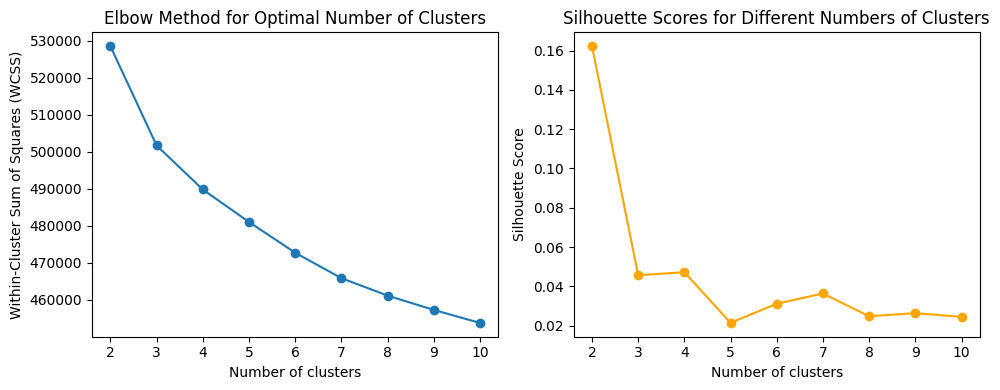

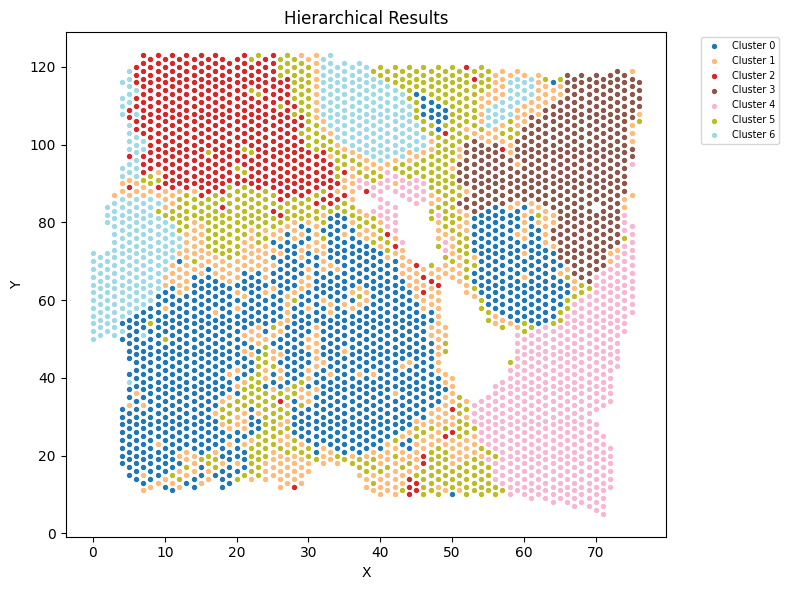

In [ ]:
# Hierarchical Clustering 

# This function clusters spatial transcriptomics spots based on 
# the similarity of their highly variable gene expression profiles.

hierarchical_results_df = dc.hierarchical.clustering(st_top_500_genes_df, coords_df)

Running DBSCAN clustering...


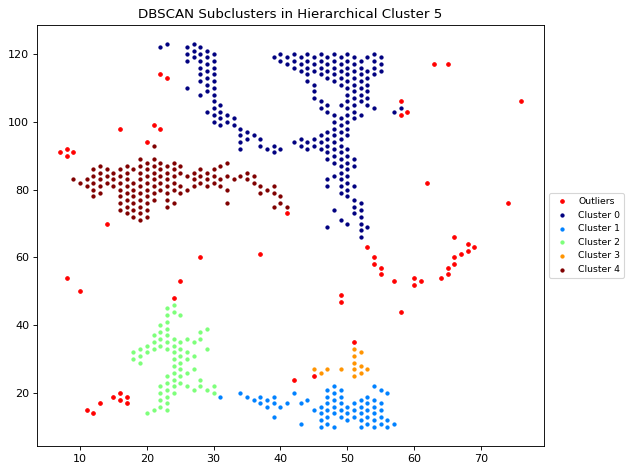

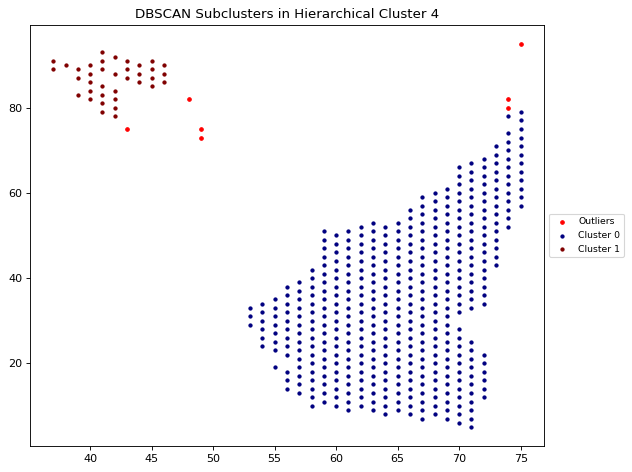

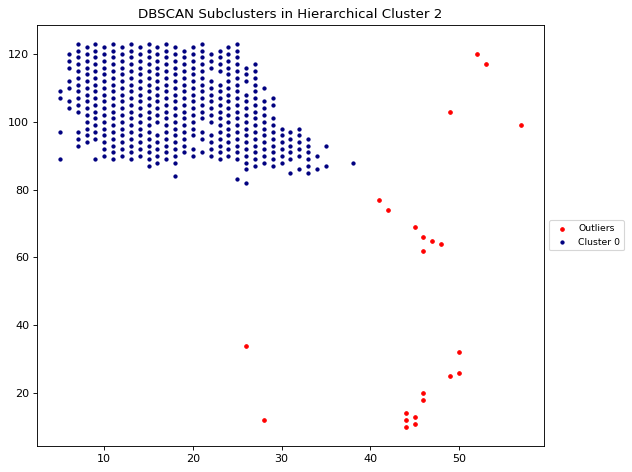

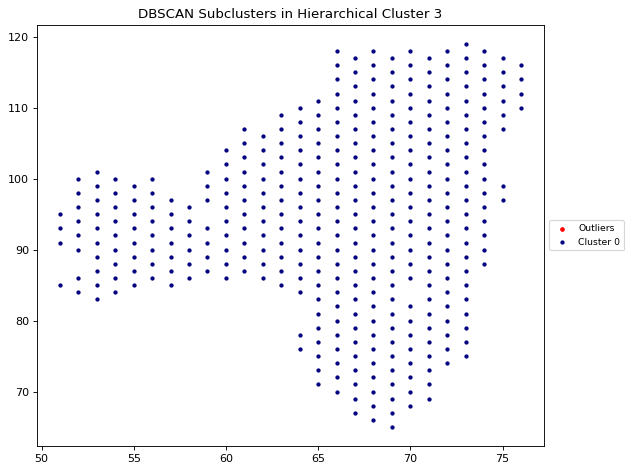

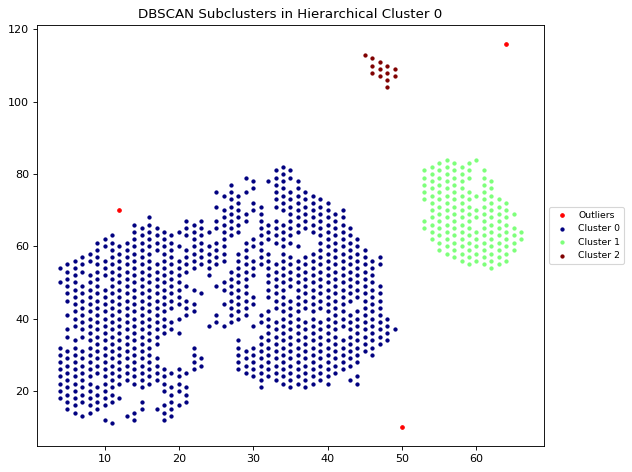

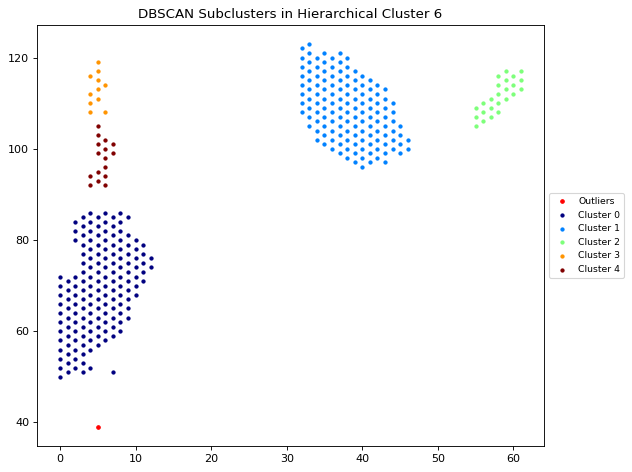

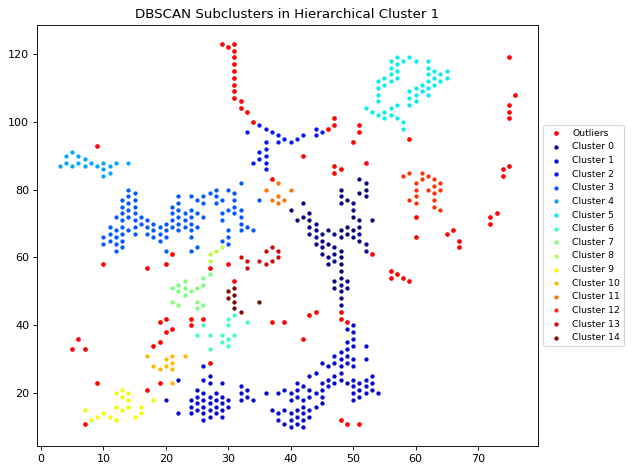

In [ ]:
# DBSCAN Clustering
  
# This function refines the initial clustering by applying DBSCAN to the results of the 
# hierarchical clustering. It also selects the initial seeds for the SRG. 
# You can choose to visualize the DBSCAN clustering results.

dbscan_centers_df = dc.dbscan.clustering(hierarchical_results_df, coords_df, visualize=True)

Running Seeded Region Growing...


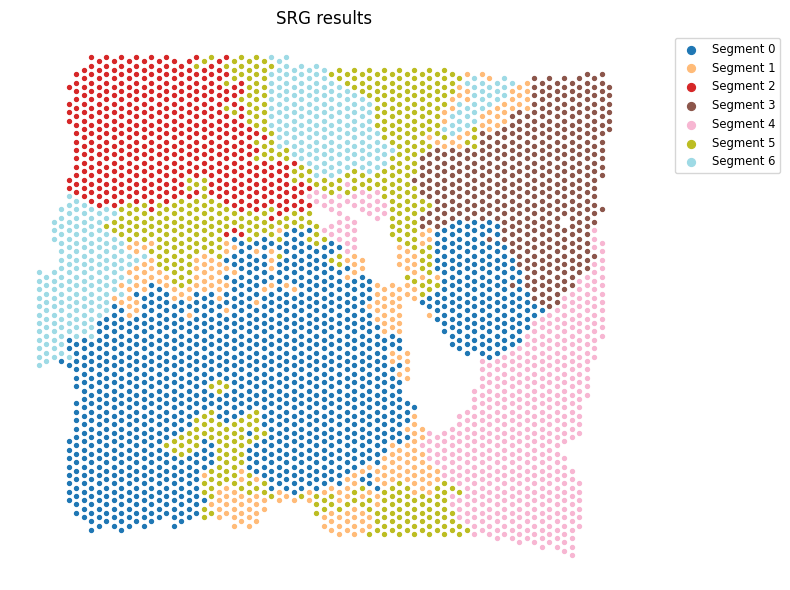

In [ ]:
# Seeded Region Growing (SRG)

# Finally, the SRG function further refines the clusters.

srg_df = dc.srg.clustering(dbscan_centers_df, coords_df, st_top_500_genes_df)

Deconvolution

In [ ]:
# You may export the pseudo-bulk gene expression profiles aggregated
# by spatial clusters by this function:

dc.deconvolution.generate_pseudo_bulk(
    st_adata, srg_df, save_csv=True, output_path="results/pseudo_bulk.csv"
)

Pseudo-bulk expression data saved to: results/pseudo_bulk.csv


,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,0.0,0.0,0.0,16.504290,0.0,0.0,0.000000,0.0,2.549867,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,148.950195,17.168467
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,39.534840,3.317922
2,0.0,0.0,0.0,4.188326,0.0,0.0,0.000000,0.0,0.839228,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,24.129044,2.534259
3,0.0,0.0,0.0,5.926351,0.0,0.0,0.000000,0.0,1.388978,0.0,...,0.0,0.0,0.295024,0.0,0.0,0.0,0.0,0.0,40.274902,3.071301
4,0.0,0.0,0.0,5.145960,0.0,0.0,0.306164,0.0,0.485095,0.0,...,0.0,0.0,0.204035,0.0,0.0,0.0,0.0,0.0,48.042374,5.278801
5,0.0,0.0,0.0,3.959404,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,56.823242,5.069404
6,0.0,0.0,0.0,3.285975,0.0,0.0,0.000000,0.0,0.159949,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,38.003216,3.184068


In [ ]:
# This function performs deconvolution using the OLS method.

DECLUST_df = dc.deconvolution.ols(st_adata, sc_adata_marker, srg_df)

Running deconvolution...


Results visulization

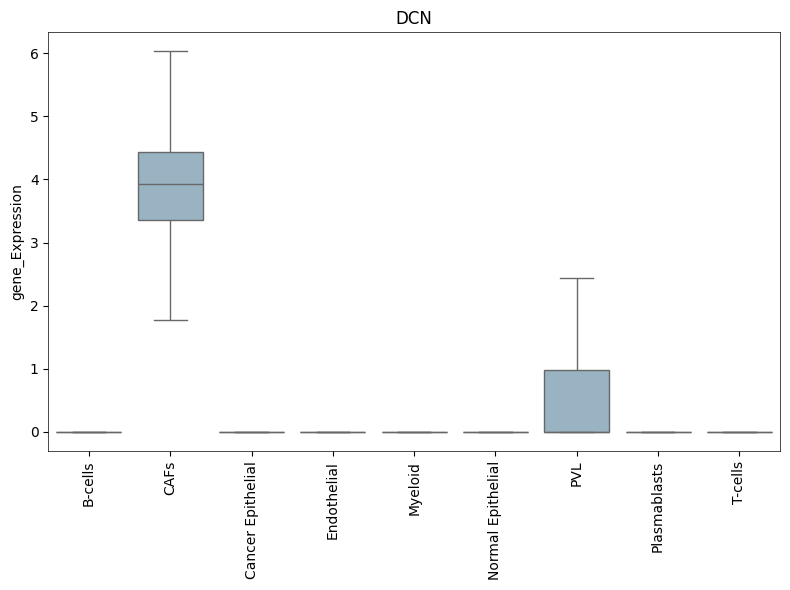

In [ ]:
# Cell-Type-Specific Marker Gene Expression

# The `dc.visualize.declust_marker_boxplot` function displays the expression levels of 
# top cell-type-specific marker genes across different cell types in the scRNA-seq reference 
# data. This helps validate the specificity of selected markers.

dc.visualize.declust_marker_boxplot(sc_adata, sc_marker_gene_df, 'DCN')

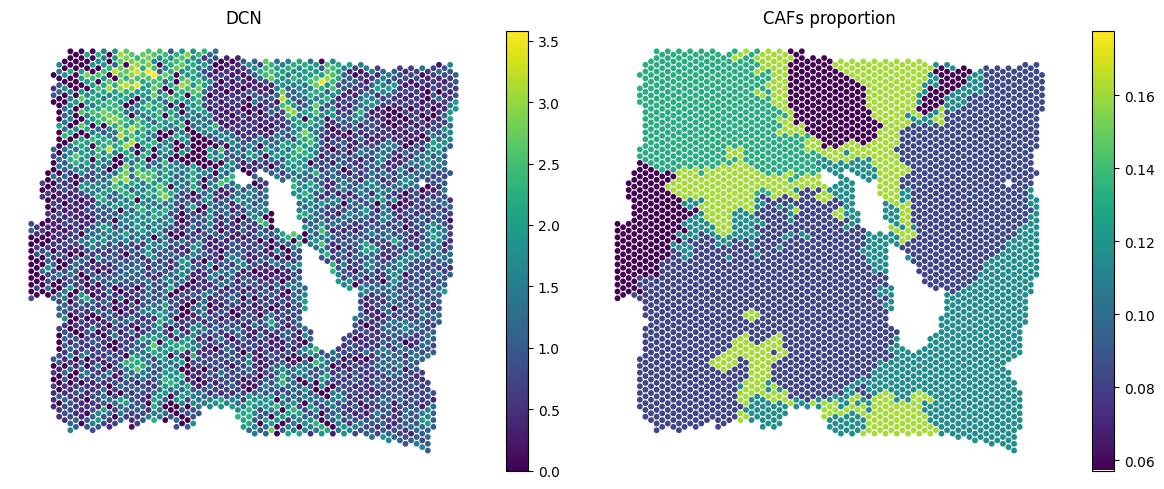

In [ ]:
# Spatial Visualization of Deconvolution Results

# The `dc.visualize.declust_results_visualize` function displays the spatial distribution 
# of deconvolved cell type proportions, along with expression patterns of marker genes in 
# the spatial transcriptomics data.

dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    gene_name='DCN', cell_type='CAFs'
)

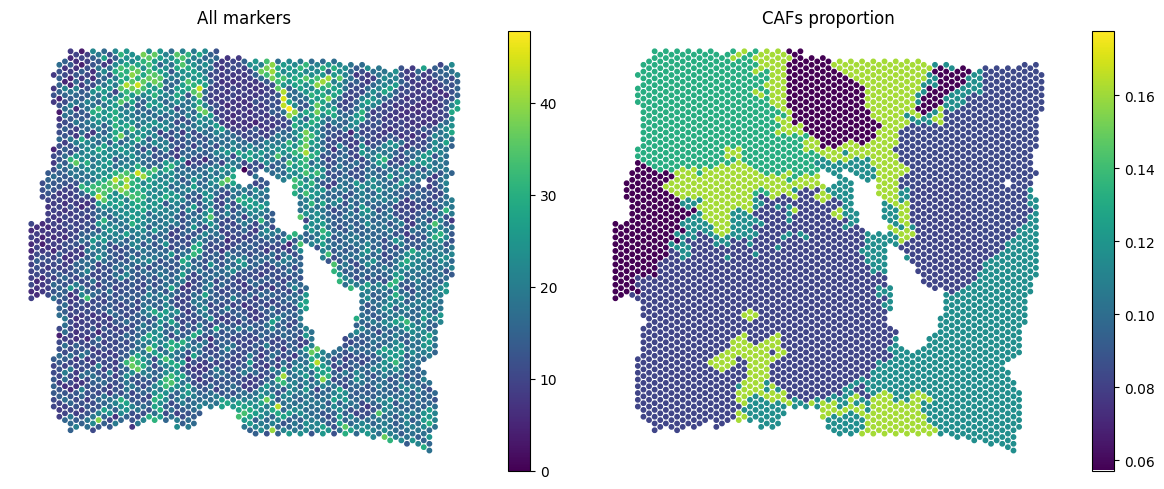

In [15]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    cell_type='CAFs', agg_method='sum'
)

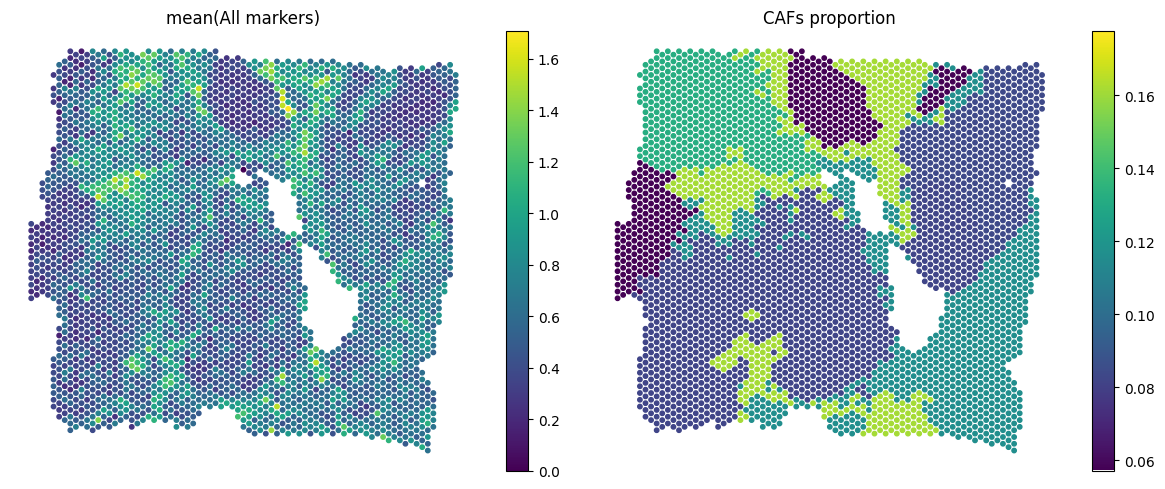

In [16]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    cell_type='CAFs', agg_method='mean'
)